## Set up data/models

In [0]:
!git clone https://github.com/ronghanghu/text_objseg.git

Cloning into 'text_objseg'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 6.38 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [0]:
! mkdir -p exp-referit/tfmodel/
! sh /content/text_objseg/exp-referit/tfmodel/download_trained_models.sh

--2019-03-25 17:17:34--  http://www.eecs.berkeley.edu/~ronghang/projects/text_objseg/models/referit_fc8_det_iter_25000.tfmodel
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~ronghang/projects/text_objseg/models/referit_fc8_det_iter_25000.tfmodel [following]
--2019-03-25 17:17:34--  https://people.eecs.berkeley.edu/~ronghang/projects/text_objseg/models/referit_fc8_det_iter_25000.tfmodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624685147 (596M)
Saving to: ‘./exp-referit/tfmodel/referit_fc8_det_iter_25000.tfmodel’

./exp-referit/tfmod 100%[===========

## Download full Referit dataset

In [0]:
! mkdir -p exp-referit/data/
! mkdir -p exp-referit/referit-dataset/

! sh /content/text_objseg/exp-referit/referit-dataset/download_referit_dataset.sh

--2019-03-25 13:46:35--  http://www.eecs.berkeley.edu/~ronghang/projects/cvpr16_text_obj_retrieval/referitdata.tar.gz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~ronghang/projects/cvpr16_text_obj_retrieval/referitdata.tar.gz [following]
--2019-03-25 13:46:35--  https://people.eecs.berkeley.edu/~ronghang/projects/cvpr16_text_obj_retrieval/referitdata.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1851336114 (1.7G) [application/x-gzip]
Saving to: ‘./exp-referit/referit-dataset/referitdata.tar.gz’

./exp-referit/refer 100%[===================>]   

In [0]:
import sys
if not 'text_objseg' in sys.path:
  sys.path += ['text_objseg']
if not '.' in sys.path:
  sys.path += ['.']

In [0]:
from __future__ import absolute_import, division, print_function

import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../')

from models import text_objseg_model as segmodel
from util import im_processing, text_processing

In [0]:
# trained model
pretrained_model = '/content/exp-referit/tfmodel/referit_fc8_seg_highres_iter_18000.tfmodel'
vocab_file = '/content/text_objseg/exp-referit/data/vocabulary_referit.txt'

In [0]:
# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500

# Inputs
text_seq_batch = tf.placeholder(tf.int32, [T, N])
imcrop_batch = tf.placeholder(tf.float32, [N, input_H, input_W, 3])

# Outputs
scores = segmodel.text_objseg_upsample32s(text_seq_batch, imcrop_batch, num_vocab,
                                          embed_dim, lstm_dim, mlp_hidden_dims,
                                          vgg_dropout=False, mlp_dropout=False)

# Load pretrained model
# Update variable names for TF 1.0.0 or higher
variable_name_mapping= None
if tf.__version__.split('.')[0] == '1':
    variable_name_mapping = {
        v.op.name.replace(
            'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel',
            'RNN/MultiRNNCell/Cell0/BasicLSTMCell/Linear/Matrix').replace(
            'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias',
            'RNN/MultiRNNCell/Cell0/BasicLSTMCell/Linear/Bias'): v
        for v in tf.global_variables()}

snapshot_restorer = tf.train.Saver(variable_name_mapping)
sess = tf.Session()
snapshot_restorer.restore(sess, pretrained_model)

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(vocab_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/exp-referit/tfmodel/referit_fc8_seg_highres_iter_18000.tfmodel


# Replicate lower cell as many times as you want for error analysis

In [0]:
# Get random file names
!ls exp-referit/referit-dataset/images | sort -R | head

38043.jpg
37911.jpg
7545.jpg
4334.jpg
25194.jpg
37684.jpg
19857.jpg
18952.jpg
22945.jpg
21604.jpg


In [0]:
# input image and query text
# Just need file name. Everything else is auto-magic
new_file = '21604.jpg'  #@param {type:"string"}
query = 'cliff' #@param {type:"string"}

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
query text = 'cliff'


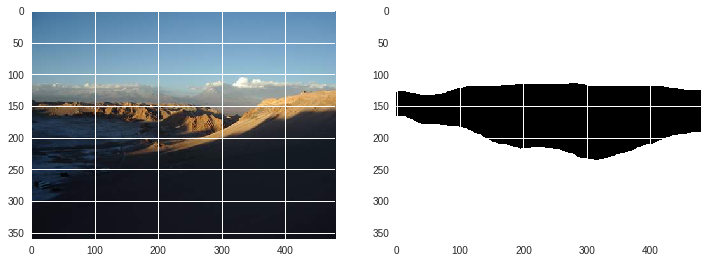

In [237]:
# DON'T TOUCH ANYTHING ELSE

import os
im_file = os.path.join('/content/exp-referit/referit-dataset/images/', new_file)

# Run on the input image and query text
text_seq_val = np.zeros((T, N), dtype=np.float32)
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)
processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, input_H, input_W))
imcrop_val[0, :] = processed_im.astype(np.float32) - segmodel.vgg_net.channel_mean
text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, T)

# Forward pass to get response map
scores_val = np.squeeze(sess.run(scores, feed_dict={text_seq_batch: text_seq_val,
                                                    imcrop_batch: imcrop_val}))

# Final prediction
prediction = im_processing.resize_and_crop(scores_val>0, *im.shape[:2]).astype(np.bool)
print(prediction)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)

In [0]:
import scipy.io
mat = scipy.io.loadmat('/content/exp-referit/referit-dataset/mask/23385_1.mat')


TypeError: ignored

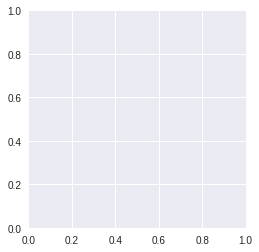

In [0]:
imgplot = plt.imshow(mat)

In [0]:
mat["segimg_t"].shape

(360, 480)